In [1]:
# imports 
import kagglehub
import pandas as pd 
import numpy as np
import os 
from PIL import Image
import PIL.Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization 

## resources: 
We referenced several of TensorFlow's website tutorials. 
* https://www.tensorflow.org/tutorials/load_data/images 
* https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory 
* https://www.tensorflow.org/guide/keras/sequential_model 
* https://www.tensorflow.org/tutorials/images/classification

## import and cleaning

In [2]:
# define and collect image paths and labels

# kaggle import 
path = kagglehub.dataset_download("syedalinaqvi/augmented-skin-conditions-image-dataset")
image_folder = os.path.join(path, "Skin_Conditions")
print("Image folder:", image_folder)
print("Subfolders (classes):", os.listdir(image_folder))

# create empty lists to hold image paths and labels
image_paths = []
labels = []

# iterate through each subfolder and collect image paths and labels
for label in sorted(os.listdir(image_folder)):
    label_folder = os.path.join(image_folder, label)

    if os.path.isdir(label_folder):
        for filename in os.listdir(label_folder):
            if filename.lower().endswith((".jpg", ".jpeg", ".png")):
                image_paths.append(os.path.join(label_folder, filename))
                labels.append(label)

Image folder: /Users/Diane/.cache/kagglehub/datasets/syedalinaqvi/augmented-skin-conditions-image-dataset/versions/1/Skin_Conditions
Subfolders (classes): ['Carcinoma', 'Keratosis', 'Acne', 'Eczema', 'Rosacea', 'Milia']


In [3]:
# create dataframe
df = pd.DataFrame({"image_path": image_paths, "labels": labels})

# remove rows w/ missing or invalid paths 
df = df[df["image_path"].apply(os.path.exists)]
df = df.drop_duplicates()

# summary (to check if it matches up w/ what kaggle says)
print(f"\nTotal images: {len(df)}")
print("Images per class:")
print(df["labels"].value_counts())


Total images: 2394
Images per class:
labels
Acne         399
Carcinoma    399
Eczema       399
Keratosis    399
Milia        399
Rosacea      399
Name: count, dtype: int64


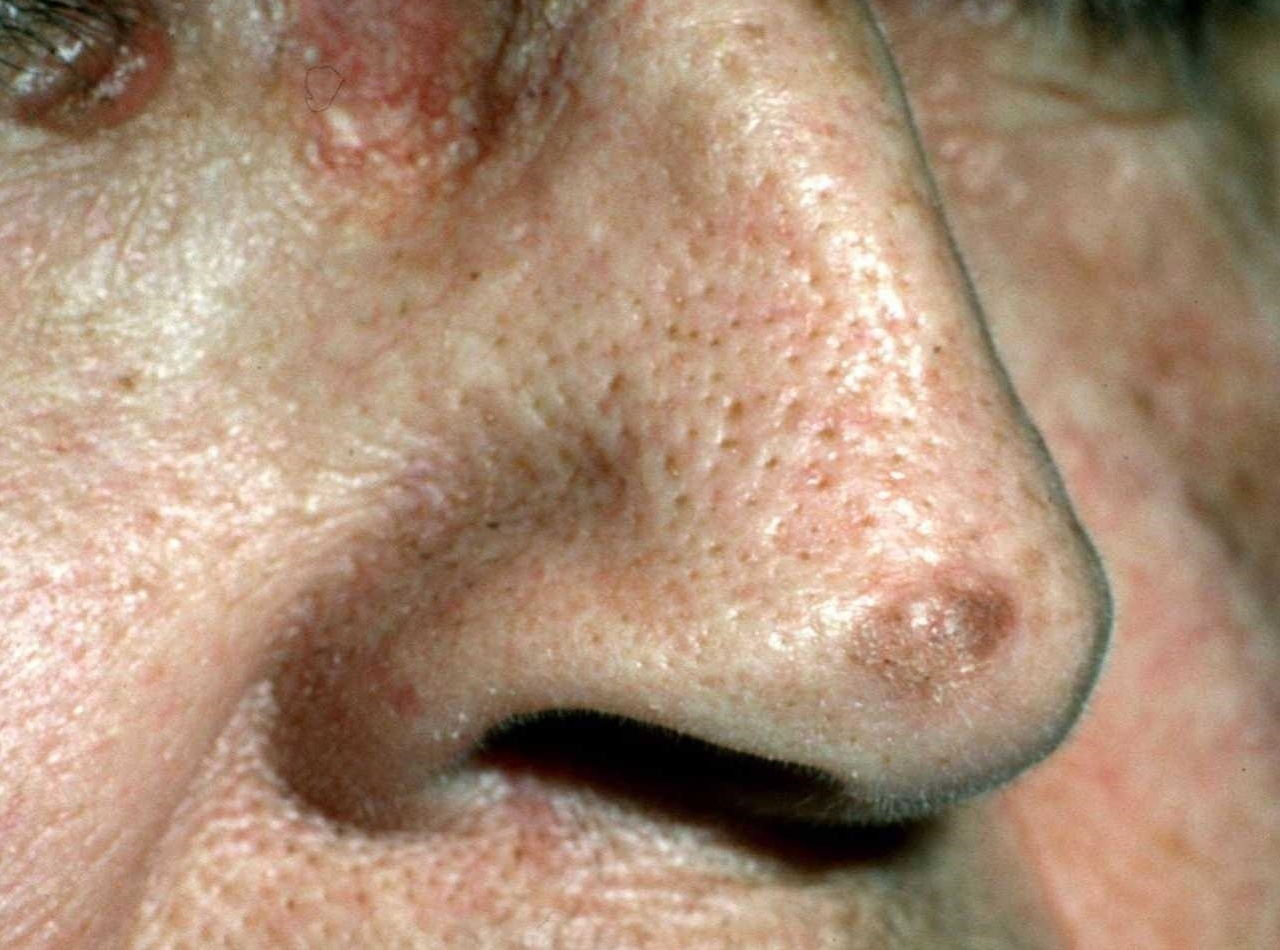

In [4]:
# view images
# preview of data and make sure everything looks normal

# from acne class
acne_images = df[df["labels"] == "Acne"]["image_path"].tolist()
PIL.Image.open(acne_images[3])

# from carcinoma class
carcinoma_images = df[df["labels"] == "Carcinoma"]["image_path"].tolist()
PIL.Image.open(carcinoma_images[3])

## initial model

In [5]:
# setting constant values 
batch_size = 32
img_height = 180
img_width = 180

# ensure reproducibility 
keras.utils.set_random_seed(101)

In [6]:
# train dataset

# using tf.kera.utils.image_dataset_from directory to generate dataset from image files in a directory

train_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="training",
  seed=123, 
  image_size=(img_height, img_width),
  batch_size=batch_size)

class_names = train_ds.class_names

Found 2394 files belonging to 6 classes.
Using 1916 files for training.


In [7]:
# validation dataset

val_ds = tf.keras.utils.image_dataset_from_directory(
  image_folder,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2394 files belonging to 6 classes.
Using 478 files for validation.


## data augmentation

In [8]:
# data augmentation to generate additional samples for training 
# reduces overfitting 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height, img_width, 3)),
    layers.RandomRotation(0.1, seed = 101),
    layers.RandomZoom(0.1, seed = 101),
  ]
)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/preprocessing/data_layer.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2025-12-10 23:12:02.231622: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


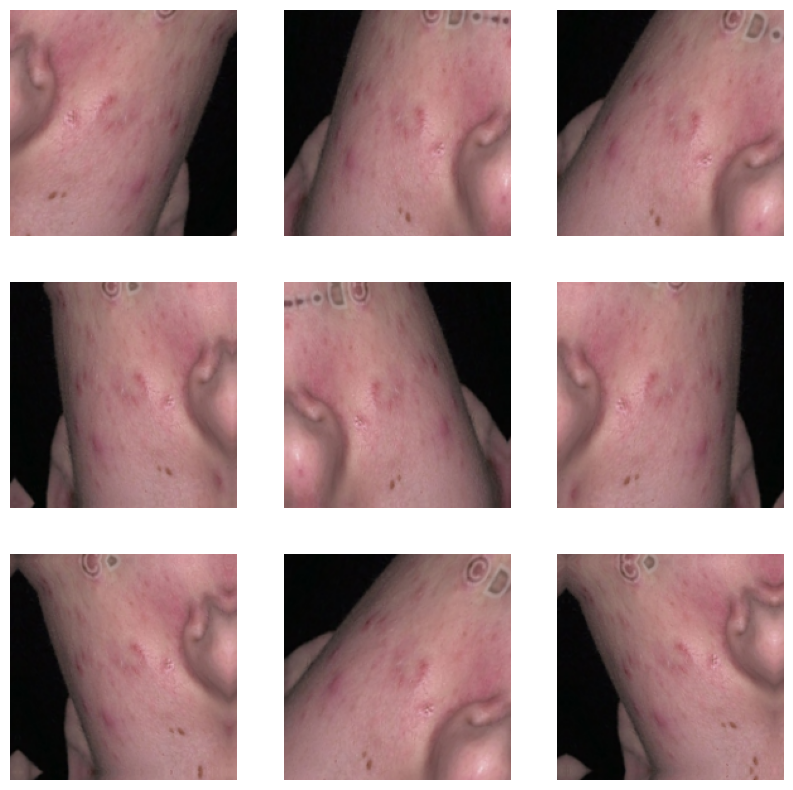

In [9]:
# display data augmentation transformation

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## data augmented model

In [10]:
# adding batchnormalization to normalize inputs for each layer to make it more stable

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

num_classes = 6

model = Sequential([

  data_augmentation,

  # we standardized data by rescaling [insert explanation abt pixel values]
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  # convolution block 1 
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),
  
  # convolution block 2
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  # convolution block 3
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  # convolution block 4
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  BatchNormalization(),
  layers.MaxPooling2D(),

  # dropout 
  layers.Dropout(0.15),

  # globalmaxpooling - included from professor's comments
  layers.GlobalMaxPooling2D(),

  # dense layers
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [11]:
# compile model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# print model summary 
model.summary()

# run model
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 180, 180, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 180, 180, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 90, 90, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 90, 90, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 90, 90, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 45, 45, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 45, 45, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 22, 22, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 22, 22, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 11, 11, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ outputs (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 115,686 (451.90 KB)

 Trainable params: 115,206 (450.02 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 649ms/step - accuracy: 0.4645 - loss: 1.6774 - val_accuracy: 0.1799 - val_loss: 1.8506
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 693ms/step - accuracy: 0.6190 - loss: 1.0567 - val_accuracy: 0.1653 - val_loss: 2.2395
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 623ms/step - accuracy: 0.6868 - loss: 0.8888 - val_accuracy: 0.1653 - val_loss: 2.5496
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 35s 582ms/step - accuracy: 0.7260 - loss: 0.7883 - val_accuracy: 0.2050 - val_loss: 2.5655
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 611ms/step - accuracy: 0.7416 - loss: 0.7228 - val_accuracy: 0.2845 - val_loss: 2.0746
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - accuracy: 0.7709 - loss: 0.6691 - val_accuracy: 0.4079 - val_loss: 1.6799
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 38s 634ms/step - accuracy: 0.7735 - loss: 0.6217 - val_accuracy: 0.5272 - val_loss: 1.3355
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 42s 694ms/step - accuracy: 0.7933 - loss: 0.5803 - val_accu

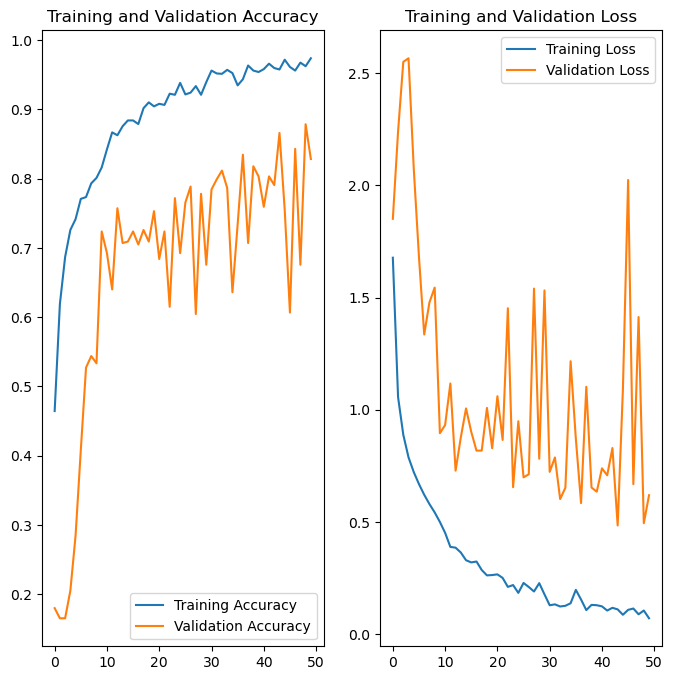

In [12]:
# define variables 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# plotting 
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## model evaluation

In [13]:
# testing on validation
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_accuracy:.4f}")

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - accuracy: 0.8285 - loss: 0.6195
Final Validation Loss: 0.6195
Final Validation Accuracy: 0.8285


In [14]:
# labeling and predictions
y_true = np.concatenate([y.numpy() for x, y in val_ds], axis=0)
y_pred_logits = np.concatenate([model(x, training=False).numpy() for x, y in val_ds], axis=0)
y_pred = np.argmax(y_pred_logits, axis=1)

# classification report
print(classification_report(y_true, y_pred, target_names=df["labels"].unique()))

# confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

2025-12-11 00:00:05.244108: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


              precision    recall  f1-score   support

        Acne       0.72      0.81      0.76        79
   Carcinoma       0.89      0.88      0.88        80
      Eczema       0.85      0.74      0.79        77
   Keratosis       0.86      0.92      0.89        85
       Milia       0.80      0.78      0.79        78
     Rosacea       0.87      0.84      0.85        79

    accuracy                           0.83       478
   macro avg       0.83      0.83      0.83       478
weighted avg       0.83      0.83      0.83       478

Confusion Matrix:
 [[64  1  5  4  2  3]
 [ 3 70  3  2  1  1]
 [ 8  1 57  1  7  3]
 [ 0  1  0 78  3  3]
 [ 6  4  1  6 61  0]
 [ 8  2  1  0  2 66]]


2025-12-11 00:00:07.296983: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


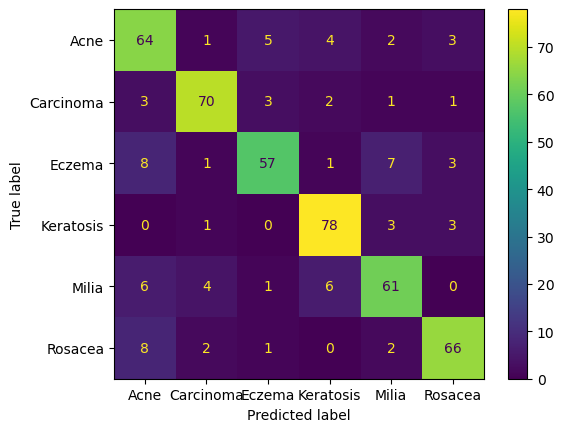

In [15]:
# confusion matrix visualization 

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm , display_labels=df["labels"].unique())
disp.plot()
plt.show()
# print("Confusion Matrix:\n", cm)